# **<font color='crimson'>SQL. Product Economics</font>**

---

In [ ]:
###

In [ ]:
--1
--получим id закзаов, которые были отменены
WITH orders_canceled AS (
    SELECT
        t.order_id AS order_id_canceled
    FROM
        user_actions AS t
    WHERE
        t.action = 'cancel_order'
),
--'разворачиваем' значения из поля product_ids,
--удаляем заказы, которые были отменены
unnest_table AS (
    SELECT
        t.order_id
        ,t.creation_time::DATE AS date
        ,UNNEST(t.product_ids) AS product_id
    FROM
        orders AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
),
--для каждого товара добавляем значение его цены
product_and_price AS (
    SELECT
        t.date
        ,t.order_id
        ,t.product_id
        ,p.price
    FROM
        unnest_table AS t
        LEFT JOIN products AS p
            ON t.product_id = p.product_id
),
--считаем выручку, полученную за каждый день
revenue AS (
    SELECT
        DISTINCT t.date
        ,SUM(t.price) OVER (PARTITION BY t.date) AS revenue
    FROM
        product_and_price AS t
    ORDER BY
        t.date ASC
)
--считаем суммарную (накопленную) выручку на текущий день;
--также дополнительно сформируем поле с расчетом прироста выручки
--относительно значения выручки за предыдущий день
SELECT
    t.date
    ,t.revenue
    ,SUM(t.revenue) OVER (ORDER BY t.date) AS total_revenue
    ,ROUND((t.revenue * 100. / LAG(t.revenue, 1) OVER ()) - 100, 2)
        AS revenue_change
FROM
    revenue AS t;

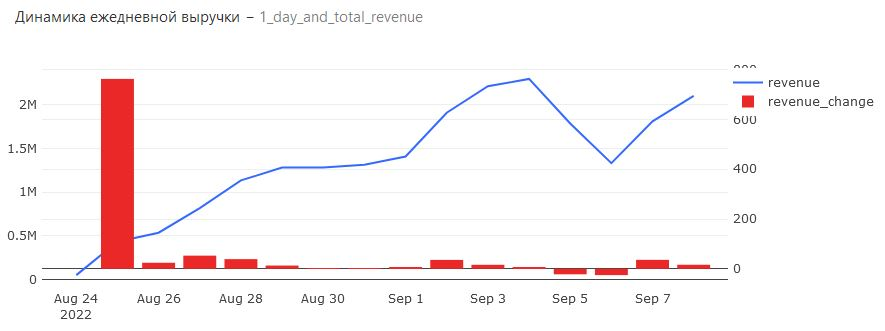

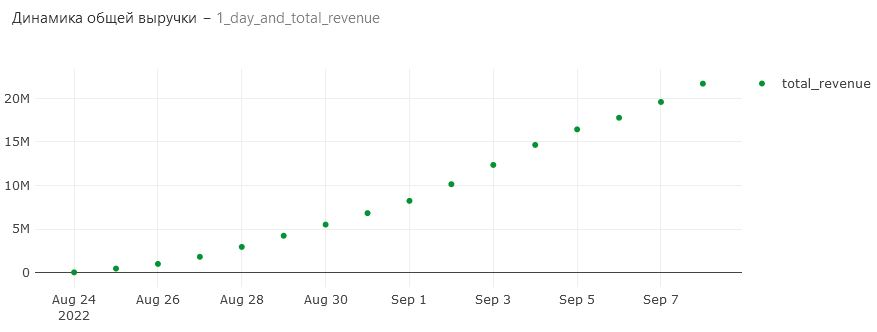

In [ ]:
###

In [ ]:
--2
--получим id отмененных заказов
WITH orders_canceled AS (
    SELECT
        t.order_id AS order_id_canceled
    FROM
        user_actions AS t
    WHERE
        t.action = 'cancel_order'
),
--посчитаем для каждого дня общее количество пользователей сервиса
total_users_per_day AS (
    SELECT
        t.time::DATE AS date
        ,COUNT(DISTINCT t.user_id) AS total_users_per_day
    FROM
        user_actions AS t
    GROUP BY
        t.time::DATE
    ORDER BY
        t.time::DATE ASC
),
--посчитаем для каждого дня количество платящих пользователей
paying_users_per_day AS (
    SELECT
        t.time::DATE AS date
        ,COUNT(DISTINCT t.user_id) AS paying_users_per_day
    FROM
        user_actions AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
    GROUP BY
        t.time::DATE
    ORDER BY
        t.time::DATE ASC
),
--для каждого дня посчитаем общее количество оплаченных заказов
total_orders_per_day AS (
    SELECT
        t.creation_time::DATE AS date
        ,COUNT(DISTINCT t.order_id) AS total_orders_per_day
    FROM
        orders AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
    GROUP BY
        t.creation_time::DATE
    ORDER BY t.creation_time::DATE ASC
),
--'развернем' значения товаров в каждом заказе из поля product_ids
--таблицы orders, удалив все отмененные заказы
unnest_table AS (
    SELECT
        t.creation_time::DATE AS date
        ,t.order_id
        ,UNNEST(t.product_ids) AS product_id
    FROM
        orders AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
    ORDER BY
        t.creation_time::DATE ASC
),
--добавим сведения о цене каждого товара в заказе
product_and_price AS (
    SELECT
        t.date
        ,t.product_id
        ,p.price
    FROM
        unnest_table AS t
        LEFT JOIN products AS p
            ON t.product_id = p.product_id
    ORDER BY
        t.date ASC
),
--для каждого дня посчитаем общую стоимость заказов
total_revenue_per_day AS (
    SELECT
        DISTINCT t.date
        ,SUM(t.price) OVER (PARTITION BY t.date) AS total_revenue_per_day
    FROM
        product_and_price AS t
    ORDER BY
        t.date ASC
),
--сформируем сводную таблицу
pivot_table AS (
    SELECT
        t.date
        ,t.total_users_per_day
        ,p.paying_users_per_day
        ,o.total_orders_per_day
        ,r.total_revenue_per_day
    FROM
        total_users_per_day AS t
        LEFT JOIN paying_users_per_day AS p
            ON t.date = p.date
        LEFT JOIN total_orders_per_day AS o
            ON t.date = o.date
        LEFT JOIN total_revenue_per_day AS r
            ON t.date = r.date
)
--рассчитаем ARPU, ARPPU, AOV
SELECT
    t.date
    ,ROUND(t.total_revenue_per_day / t.total_users_per_day, 2)
        AS arpu
    ,ROUND(t.total_revenue_per_day / t.paying_users_per_day, 2)
        AS arppu
    ,ROUND(t.total_revenue_per_day / t.total_orders_per_day, 2)
        AS aov
FROM
    pivot_table AS t
ORDER BY
    t.date ASC;

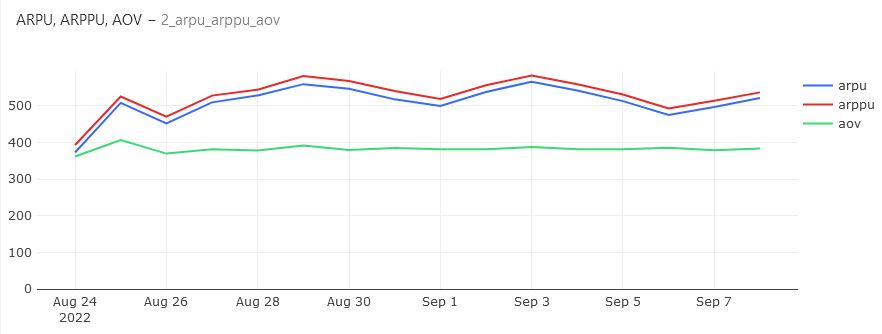

In [ ]:
###

In [ ]:
--3
--получим id отмененных заказов
WITH orders_canceled AS (
    SELECT
        t.order_id AS order_id_canceled
    FROM
        user_actions AS t
    WHERE
        t.action = 'cancel_order'
),
--для каждого дня посчитаем общее количество оплаченных заказов
total_orders_per_day AS (
    SELECT
        t.creation_time::DATE AS date
        ,COUNT(DISTINCT t.order_id) AS total_orders_per_day
    FROM
        orders AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
    GROUP BY
        t.creation_time::DATE
    ORDER BY t.creation_time::DATE ASC
),
--для каждого дня посчитаем накопленное
--общее количество оплаченных заказов
cumulative_total_orders_per_day AS (
SELECT
    t.date
    ,t.total_orders_per_day
    ,SUM(t.total_orders_per_day) OVER (ORDER BY t.date ASC)
        AS cumulative_total_orders_per_day
FROM
    total_orders_per_day AS t
ORDER BY
    t.date
),
--'развернем' значения товаров в каждом заказе из поля product_ids
--таблицы orders, удалив все отмененные заказы
unnest_table AS (
    SELECT
        t.creation_time::DATE AS date
        ,t.order_id
        ,UNNEST(t.product_ids) AS product_id
    FROM
        orders AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
    ORDER BY
        t.creation_time::DATE ASC
),
--добавим сведения о цене каждого товара в заказе
product_and_price AS (
    SELECT
        t.date
        ,t.product_id
        ,p.price
    FROM
        unnest_table AS t
        LEFT JOIN products AS p
            ON t.product_id = p.product_id
    ORDER BY
        t.date ASC
),
--для каждого дня посчитаем общую стоимость заказов
total_revenue_per_day AS (
    SELECT
        DISTINCT t.date
        ,SUM(t.price) OVER (PARTITION BY t.date)
            AS total_revenue_per_day
    FROM
        product_and_price AS t
    ORDER BY
        t.date ASC
),
--для каждого дня посчитаем накопленную
--общую стоимость заказов
cumulative_total_revenue_per_day AS(
    SELECT
        t.date
        ,t.total_revenue_per_day
        ,SUM(t.total_revenue_per_day) OVER (ORDER BY t.date ASC)
            AS cumulative_total_revenue_per_day
    FROM
        total_revenue_per_day AS t
    ORDER BY
        t.date
),
--для каждого пользователя
--получим самую раннюю дату совершения заказа
--(в тч. для пользователей, отменивших заказ)
first_user_day AS (
    SELECT
        DISTINCT t.time::DATE AS date
        ,t.user_id
        ,MIN(t.time::DATE)
            OVER (PARTITION BY t.user_id)
            AS first_user_day
    FROM
        user_actions AS t
    ORDER BY
        t.time::DATE ASC
),
--для каждого дня посчитаем количество пользователей,
--впервые оформивших заказ в отчетный день
--(в т.ч. для пользователей, отменивших заказ)
count_all_users_per_day AS (
    SELECT
        t.first_user_day AS date
        ,COUNT(DISTINCT t.user_id)
            AS count_all_users_per_day
    FROM
        first_user_day AS t
    GROUP BY
        t.first_user_day
    ORDER BY
        t.first_user_day ASC
),
--для каждого дня посчитаем накопленное число
--пользователей, впервые оформивших заказ
--(в т.ч. пользователей, отменивших заказ)
cumulative_total_users_per_day AS (
    SELECT
        t.date
        ,SUM(t.count_all_users_per_day)
            OVER (ORDER BY t.date ASC)
            AS cumulative_total_users_per_day
    FROM
        count_all_users_per_day AS t
    ORDER BY
        t.date ASC
),
--для каждого пользователя
--получим самую раннюю дату совершения заказа
--(исключая пользователей, отменивших заказ)
first_user_day_non_cancel AS (
    SELECT
        DISTINCT t.time::DATE AS date
        ,t.user_id
        ,MIN(t.time::DATE)
            OVER (PARTITION BY t.user_id)
            AS first_user_day_non_cancel
    FROM
        user_actions AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
        AND t.action = 'create_order'
    ORDER BY
        t.time::DATE ASC
),
--для каждого дня посчитаем количество пользователей,
--впервые оформивших заказ в отчетный день
--(исключая пользователей, отменивших заказ)
count_non_cancel_users_per_day AS (
    SELECT
        t.first_user_day_non_cancel AS date
        ,COUNT(DISTINCT t.user_id)
            AS count_non_cancel_users_per_day
    FROM
        first_user_day_non_cancel AS t
    GROUP BY
        t.first_user_day_non_cancel
    ORDER BY
        t.first_user_day_non_cancel ASC
),
--для каждого дня посчитаем накопленное число
--пользователей, впервые оформивших заказ
--(исключая пользователей, отменивших заказ)
cumulative_paying_users_per_day AS (
    SELECT
        t.date
        ,SUM(t.count_non_cancel_users_per_day)
            OVER (ORDER BY t.date ASC)
            AS cumulative_paying_users_per_day
    FROM
        count_non_cancel_users_per_day AS t
    ORDER BY
        t.date ASC
),

--сформируем сводную таблицу
pivot_table AS (
    SELECT
        t.date
        ,t.cumulative_total_users_per_day
        ,p.cumulative_paying_users_per_day
        ,o.cumulative_total_orders_per_day
        ,r.cumulative_total_revenue_per_day
    FROM
        cumulative_total_users_per_day AS t
        LEFT JOIN cumulative_paying_users_per_day AS p
            ON t.date = p.date
        LEFT JOIN cumulative_total_orders_per_day AS o
            ON t.date = o.date
        LEFT JOIN cumulative_total_revenue_per_day AS r
            ON t.date = r.date
)
--рассчитаем running_ARPU, running_ARPPU, running_AOV
SELECT
    t.date
    ,ROUND(t.cumulative_total_revenue_per_day /
        t.cumulative_total_users_per_day, 2)
        AS running_arpu
    ,ROUND(t.cumulative_total_revenue_per_day /
        t.cumulative_paying_users_per_day, 2)
        AS running_arppu
    ,ROUND(t.cumulative_total_revenue_per_day /
        t.cumulative_total_orders_per_day, 2)
        AS running_aov
FROM
    pivot_table AS t
ORDER BY
    t.date ASC;

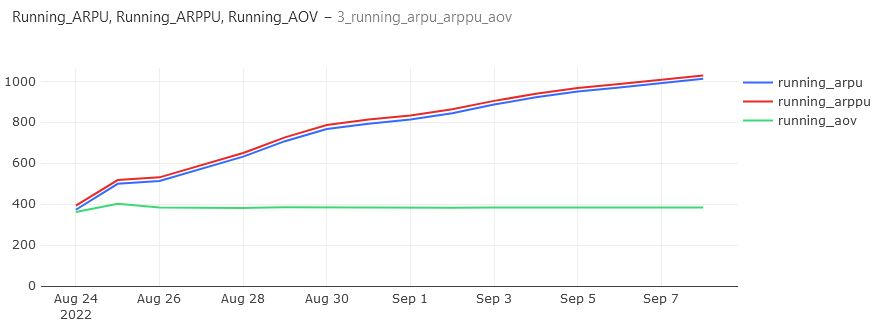

In [ ]:
###

In [ ]:
--4
--получим id отмененных заказов
WITH orders_canceled AS (
    SELECT
        t.order_id AS order_id_canceled
    FROM
        user_actions AS t
    WHERE
        t.action = 'cancel_order'
),
--посчитаем для каждого дня общее количество пользователей сервиса
total_users_per_day AS (
    SELECT
        t.time::DATE AS date
        ,COUNT(DISTINCT t.user_id) AS total_users_per_day
    FROM
        user_actions AS t
    WHERE
        t.time::DATE BETWEEN '2022-08-26' AND '2022-09-08'
    GROUP BY
        t.time::DATE
    ORDER BY
        t.time::DATE ASC
),
--посчитаем для каждого дня количество платящих пользователей
paying_users_per_day AS (
    SELECT
        t.time::DATE AS date
        ,COUNT(DISTINCT t.user_id) AS paying_users_per_day
    FROM
        user_actions AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
        AND t.time::DATE BETWEEN '2022-08-26' AND '2022-09-08'
    GROUP BY
        t.time::DATE
    ORDER BY
        t.time::DATE ASC
),
--для каждого дня посчитаем общее количество оплаченных заказов
total_orders_per_day AS (
    SELECT
        t.creation_time::DATE AS date
        ,COUNT(DISTINCT t.order_id) AS total_orders_per_day
    FROM
        orders AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
        AND t.creation_time::DATE BETWEEN '2022-08-26' AND '2022-09-08'
    GROUP BY
        t.creation_time::DATE
    ORDER BY t.creation_time::DATE ASC
),
--'развернем' значения товаров в каждом заказе из поля product_ids
--таблицы orders, удалив все отмененные заказы
unnest_table AS (
    SELECT
        t.creation_time::DATE AS date
        ,t.order_id
        ,UNNEST(t.product_ids) AS product_id
    FROM
        orders AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
        AND t.creation_time::DATE BETWEEN '2022-08-26' AND '2022-09-08'
    ORDER BY
        t.creation_time::DATE ASC
),
--добавим сведения о цене каждого товара в заказе
product_and_price AS (
    SELECT
        t.date
        ,t.product_id
        ,p.price
    FROM
        unnest_table AS t
        LEFT JOIN products AS p
            ON t.product_id = p.product_id
    WHERE
        t.date::DATE BETWEEN '2022-08-26' AND '2022-09-08'
    ORDER BY
        t.date ASC
),
--для каждого дня посчитаем общую стоимость заказов
total_revenue_per_day AS (
    SELECT
        DISTINCT t.date
        ,SUM(t.price) OVER (PARTITION BY t.date) AS total_revenue_per_day
    FROM
        product_and_price AS t
    WHERE
        t.date::DATE BETWEEN '2022-08-26' AND '2022-09-08'
    ORDER BY
        t.date ASC
),
--сформируем сводную таблицу
pivot_table AS (
    SELECT
        t.date
        ,t.total_users_per_day
        ,p.paying_users_per_day
        ,o.total_orders_per_day
        ,r.total_revenue_per_day
    FROM
        total_users_per_day AS t
        LEFT JOIN paying_users_per_day AS p
            ON t.date = p.date
        LEFT JOIN total_orders_per_day AS o
            ON t.date = o.date
        LEFT JOIN total_revenue_per_day AS r
            ON t.date = r.date
),
--выделим из дат названия дней недели
--и номера дней недели
pivot_table_weekday AS (
    SELECT
        TO_CHAR(t.date, 'DAY') AS weekday
        ,DATE_PART('isodow', t.date)::INT weekday_number
        ,t.total_users_per_day
        ,t.paying_users_per_day
        ,t.total_orders_per_day
        ,t.total_revenue_per_day
    FROM
        pivot_table AS t
),
--агрегируем расчетные показатели по дням недели
pivot_table_aggregated AS (
    SELECT
        DISTINCT t.weekday
        ,t.weekday_number
        ,SUM(t.total_users_per_day)
            OVER (PARTITION BY t.weekday)
            AS total_users_per_day
        ,SUM(t.paying_users_per_day)
            OVER (PARTITION BY t.weekday)
            AS paying_users_per_day
        ,SUM(t.total_orders_per_day)
            OVER (PARTITION BY t.weekday)
            AS total_orders_per_day
        ,SUM(t.total_revenue_per_day)
            OVER (PARTITION BY t.weekday)
            AS total_revenue_per_day
    FROM
        pivot_table_weekday AS t
)
--рассчитаем ARPU, ARPPU, AOV
SELECT
    t.weekday
    ,t.weekday_number
    ,ROUND(t.total_revenue_per_day / t.total_users_per_day, 2)
        AS arpu
    ,ROUND(t.total_revenue_per_day / t.paying_users_per_day, 2)
        AS arppu
    ,ROUND(t.total_revenue_per_day / t.total_orders_per_day, 2)
        AS aov
FROM
    pivot_table_aggregated AS t
ORDER BY
    t.weekday_number ASC;

In [ ]:
SELECT
    t.weekday
    ,t.weekday_number
    ,SUM(t.total_users_per_day) AS t.total_users_per_day
    ,SUM(t.paying_users_per_day) AS t.paying_users_per_day
    ,SUM(t.total_orders_per_day) AS t.total_orders_per_day
    ,SUM(t.total_revenue_per_day) AS t.total_revenue_per_day
FROM
    pivot_table_weekday AS t
GROUP BY
    t.weekday
    ,t.weekday_number

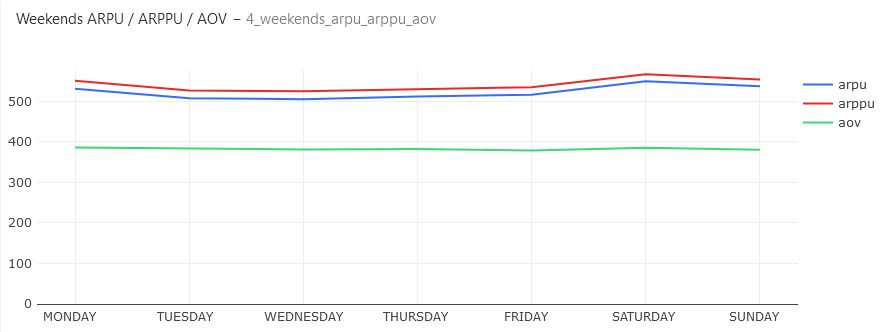

In [ ]:
###

In [ ]:
--5
--получим id отмененных заказов
WITH orders_canceled AS (
    SELECT
        t.order_id AS order_id_canceled
    FROM
        user_actions AS t
    WHERE
        t.action = 'cancel_order'
),
--'разворачиваем' списки с id товаров из поля product_ids,
--удаляем все заказы, которые были отменены пользователем
unnest_table AS(
    SELECT
        t.creation_time::DATE AS date
        ,t.order_id
        ,UNNEST(t.product_ids) AS product_id
    FROM
        orders AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
    ORDER BY
        t.creation_time::DATE
),
--добавим сведения о стоимости каждого товара
product_price_table AS (
    SELECT
        t.date
        ,t.order_id
        ,t.product_id
        ,p.price
    FROM
        unnest_table AS t
        LEFT JOIN products AS p
            ON t.product_id = p.product_id
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
    ORDER BY
        t.date ASC
),
--вычислим выручку за каждый день
revenue AS (
    SELECT
        DISTINCT t.date
        ,SUM(t.price) OVER (PARTITION BY t.date) AS revenue
    FROM
        product_price_table AS t
    ORDER BY
        t.date
),
--вычислим стоимость каждого неотмененного заказа
order_cost AS (
SELECT
    DISTINCT t.date
    ,t.order_id
    ,SUM(t.price) OVER (PARTITION BY t.order_id) AS order_cost
FROM
    product_price_table AS t
ORDER BY
    t.date ASC
    ,t.order_id ASC
),
--определим дату первого действия каждого пользователя сервиса
first_date AS (
    SELECT
        DISTINCT t.time::DATE AS date
        ,t.user_id
        ,t.order_id
        ,MIN(t.time::DATE) OVER (PARTITION BY t.user_id) AS first_date
    FROM
        user_actions AS t
    ORDER BY
        t.time::DATE ASC
        ,t.user_id ASC
),
--объединим данные о стоимости заказов
--с данными о действиях пользователей
--и датой самого первого действия каждого пользователя,
--исключив id отмененных пользователями заказов
pivot_table AS(
    SELECT
        t.time::DATE AS date
        ,t.user_id
        ,t.order_id
        ,o.order_cost
        ,f.first_date
    FROM
        user_actions AS t
            LEFT JOIN order_cost AS o
                ON t.order_id = o.order_id
            LEFT JOIN first_date AS f
                ON t.user_id = f.user_id
                    AND t.order_id = f.order_id
    WHERE
        t.order_id NOT IN (
        SELECT t.order_id_canceled
        FROM orders_canceled AS t)
    ORDER BY
        t.time::DATE
    LIMIT 57000
),
--отфильтруем сведения о заказах,
--которые были сделаны в первый день активности
--каждого пользователя
pivot_table_filtered AS (
    SELECT
        t.date
        ,t.user_id
        ,t.order_id
        ,t.order_cost
        ,t.first_date
    FROM
        pivot_table AS t
    WHERE
        t.date = t.first_date
    ORDER BY
        t.date
        ,t.user_id
),
--вычислим суммарную выручку с новых пользователей
--за каждый день
new_users_revenue AS (
    SELECT
        DISTINCT t.date
        ,SUM(t.order_cost)
            OVER (PARTITION BY t.date)
            AS new_users_revenue
    FROM
        pivot_table_filtered AS t
)
--объединим рассчитанные значения выручки, полученной за каждый день,
--и выручки с заказов новых пользователей за каждый день;
--также рассчитаем долю выручки с заказов новых пользователей
--в общей выручке за текущий день, и долю выручки с заказов
--остальных пользователей в общей выручке за текущий день
SELECT
    t.date
    ,t.revenue
    ,n.new_users_revenue
    ,ROUND(n.new_users_revenue * 100. / t.revenue, 2)
        AS new_users_revenue_share
    ,ROUND(100 - n.new_users_revenue * 100. / t.revenue, 2)
        AS old_users_revenue_share
FROM
    revenue AS t
    LEFT JOIN new_users_revenue AS n
        ON t.date = n.date
ORDER BY
    t.date ASC;

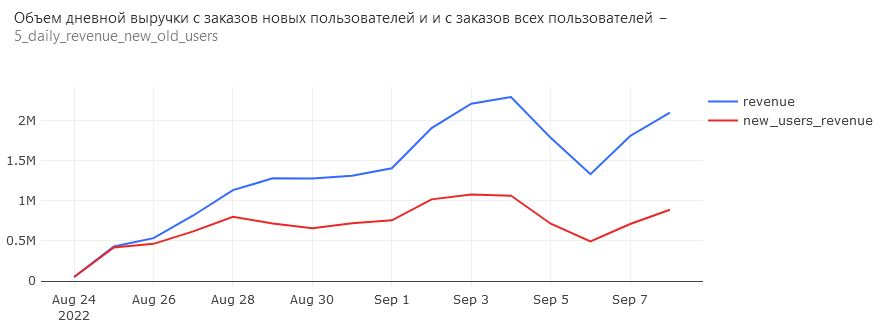

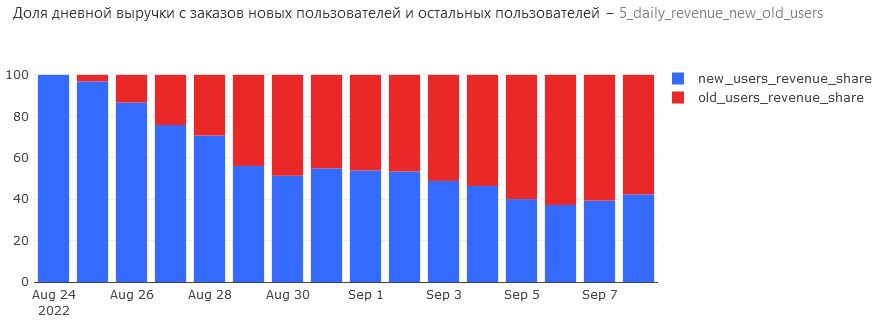

In [ ]:
###

In [ ]:
--6
--получим id отмененных заказов
WITH orders_canceled AS (
    SELECT
        t.order_id AS order_id_canceled
    FROM
        user_actions AS t
    WHERE
        t.action = 'cancel_order'
),
--'разворачиваем' списки с id товаров из поля product_ids,
--удаляем все заказы, которые были отменены пользователем
unnest_table AS(
    SELECT
        t.creation_time::DATE AS date
        ,t.order_id
        ,UNNEST(t.product_ids) AS product_id
    FROM
        orders AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
    ORDER BY
        t.creation_time::DATE
),
--добавим сведения о стоимости каждого товара
product_price_table AS (
    SELECT
        t.date
        ,t.order_id
        ,t.product_id
        ,p.price
        ,p.name
    FROM
        unnest_table AS t
        LEFT JOIN products AS p
            ON t.product_id = p.product_id
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
    ORDER BY
        t.date ASC
),
--посчитаем суммарную выручку, полученную от продажи
--каждого товара за весь период
revenue AS (
    SELECT
        DISTINCT t.name AS product_name
        ,SUM(t.price) OVER (PARTITION BY t.name) AS revenue
    FROM
        product_price_table AS t
    ORDER BY
        SUM(t.price) OVER (PARTITION BY t.name) DESC
),
--в отдельном поле представим сведения об общей выручке по всем товарам
total_revenue AS (
    SELECT
        t.product_name
        ,t.revenue
        ,SUM(t.revenue) OVER () AS total_revenue
    FROM
        revenue AS t
),
--рассчитаем долю выручки каждого товара в общей выручке,
--полученной за весь период
share_in_revenue AS (
    SELECT
        t.product_name
        ,t.revenue
        ,ROUND(t.revenue *100. / t.total_revenue, 2) AS share_in_revenue
    FROM
        total_revenue AS t
    ORDER BY
        t.revenue DESC
),
--товары, доля реализации которых в общей стоимости менее 0.5%,
--отнесем к категории ДРУГОЕ
other AS (
    SELECT
        CASE
        WHEN t.share_in_revenue > 0.5 THEN t.product_name
        ELSE 'ДРУГОЕ'
        END AS product_name
        ,t.revenue
        ,t.share_in_revenue
    FROM
        share_in_revenue AS t
    ORDER BY
        t.revenue DESC
)
--для категории товаров ДРУГОЕ сгруппируем значения
--полей revenue и share_in_revenue
SELECT
    t.product_name
    ,SUM(t.revenue) AS revenue
    ,SUM(t.share_in_revenue) AS share_in_revenue
FROM
    other AS t
GROUP BY
    t.product_name
ORDER BY
    SUM(t.revenue) DESC;

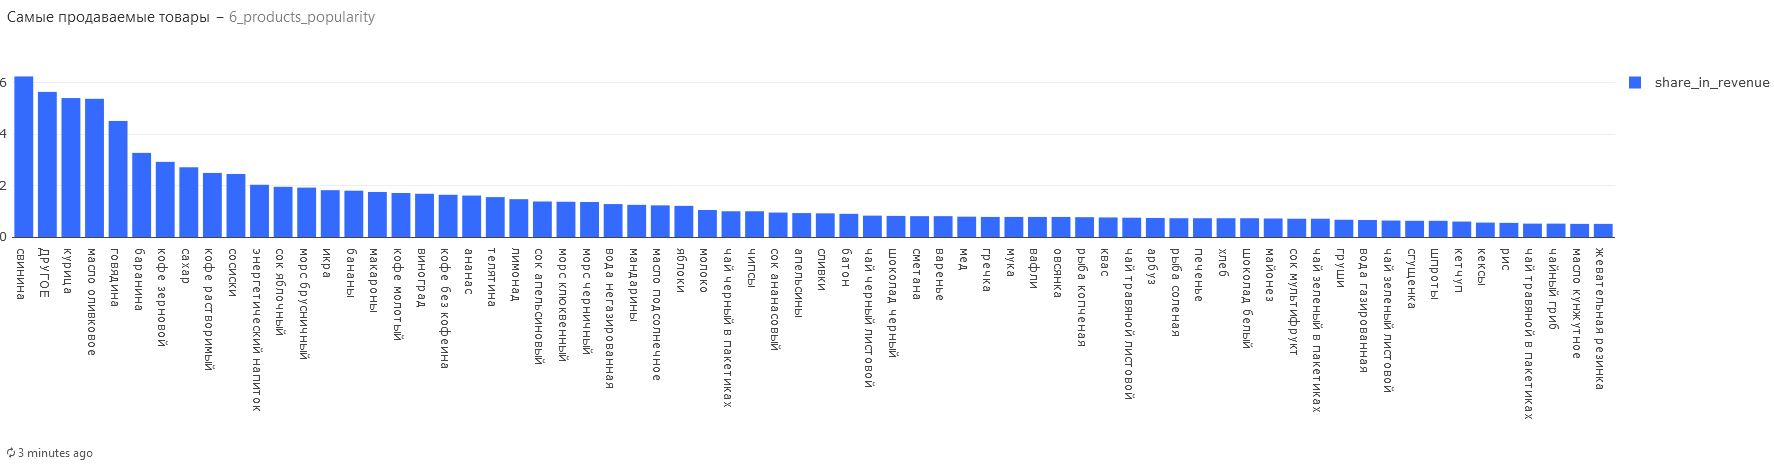